In [7]:
from pyvi import ViTokenizer
import numpy as np
import os
import torch
from flask import Flask, request,render_template,jsonify
from flask_cors import CORS
import torch.nn as nn
import flask
app = Flask(__name__)
CORS(app)


def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

def tokenize(text):
    list_token = ViTokenizer.tokenize(text)
    return list_token.split(' ')

def encode_sentence(text, vocab2index, N=100):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
#     print(len(enc1))
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
#     print(len(encoded))
    encoded_array = torch.from_numpy(encoded.astype(np.float32))
    encoded_array = torch.reshape(encoded_array,(1,N))
    
    ## padding
    pad_enc = torch.zeros([29,N])
    encoded_array_pad = torch.cat([encoded_array,pad_enc])
    return encoded_array_pad.long()



@app.route('/predict',methods=['POST'])
def predict():
    # text=request.get_data(as_text=True)
    input_data = request.get_json(force=True)
    text = input_data['message']
    enc_vector = encode_sentence(text,vocab2index,22)
    preds = load_model(enc_vector)
    prop_preds = nn.functional.softmax(preds,dim=1)
    pred_label = prop_preds.argmax().item()
    label = ['0' , '1' , '2' , '3' , '4' , '5' , '6' , '7']
    # return label[pred_label]
    return jsonify({"intent": label[pred_label]})

model_path = '../model'
load_model = load_checkpoint(os.path.join(model_path,'best.pth'))
vocab2index = torch.load(os.path.join(model_path,'vocab_12jul.pth'))


In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
words = [item.replace('_',' ') for item in list(vocab2index.keys())]
# words
comment_words = ''
comment_words += " ".join(words)

In [9]:
# comment_words

In [10]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
#                 stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

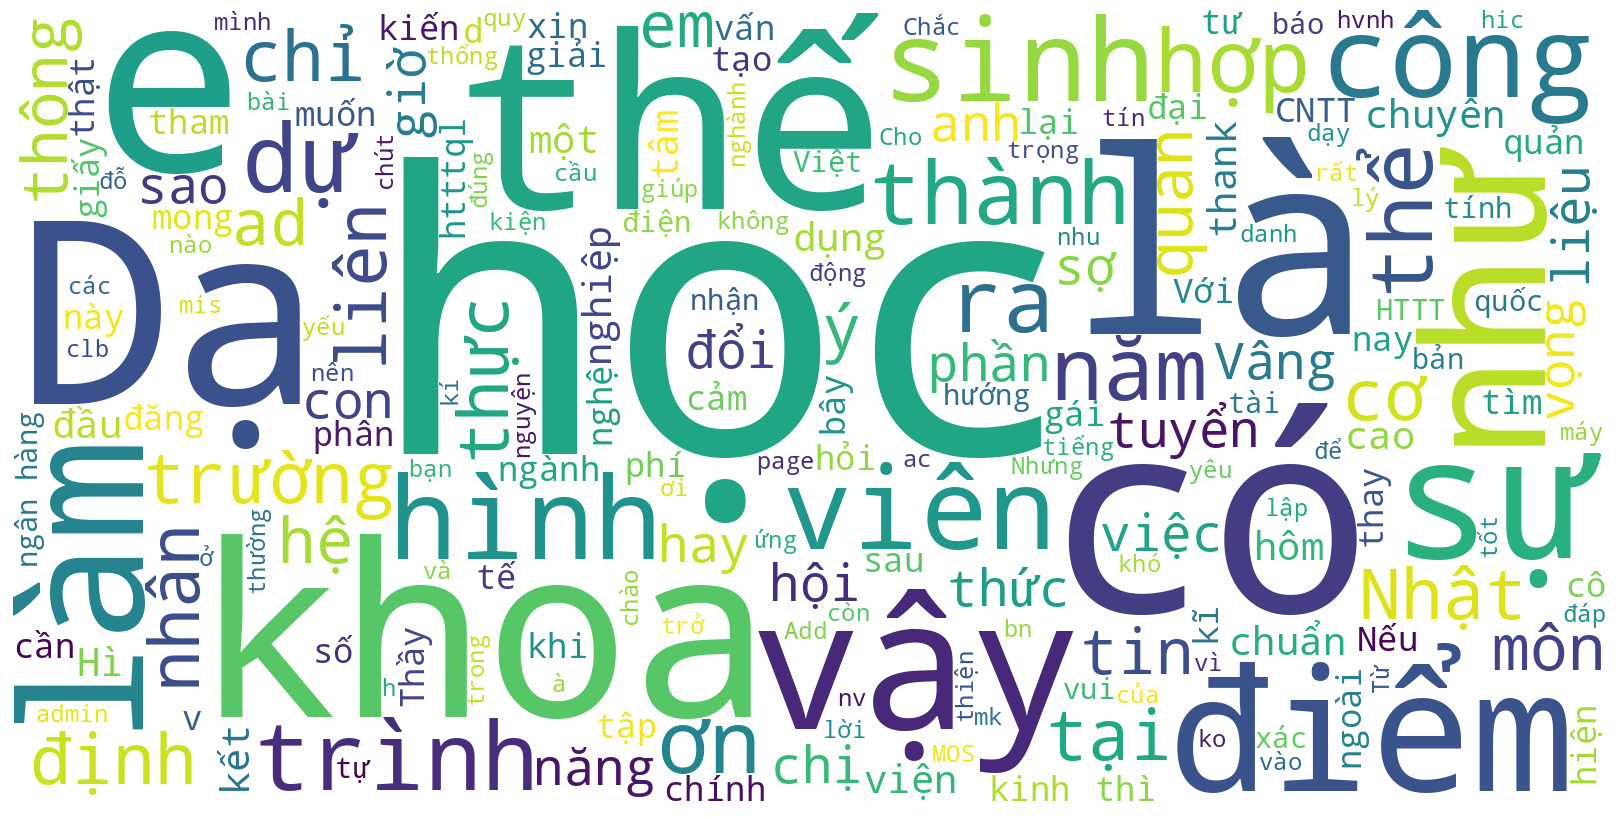

In [11]:

 
# plot the WordCloud image                      
plt.figure(figsize = (16, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [12]:
plt.savefig('./wordclouds.png')
# plt.close(fig)

<Figure size 640x480 with 0 Axes>

In [13]:
if __name__=="__main__":
    port=int(os.environ.get('PORT',5005))
    app.run(port=port,debug=True,use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5005
Press CTRL+C to quit
